In [ ]:
from tensorflow.keras import models, layers, datasets
import tensorflow as tf
import matplotlib.pyplot as plt
import math
import numpy as np
from collections import defaultdict
# Fix the random seeds
np.random.seed(42)
tf.random.set_seed(42)

In [0]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()
# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

In [0]:
train_images = train_images[..., tf.newaxis]
test_images = test_images[..., tf.newaxis]
train_images.shape

(60000, 28, 28, 1)

In [0]:
# Define the model
def get_training_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10))
    model.add(layers.Softmax())

    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE),
              metrics=['accuracy'])
    
    return model

In [0]:
model = get_training_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

In [0]:
model = get_training_model()
history = model.fit(train_images, train_labels, epochs=4, 
                    validation_data=(test_images, test_labels))

Epoch 1/4
1875/1875 [==============================] - 55s 29ms/step - loss: 1.6223 - accuracy: 0.8404 - val_loss: 1.5700 - val_accuracy: 0.8912
Epoch 2/4
1875/1875 [==============================] - 54s 29ms/step - loss: 1.5634 - accuracy: 0.8974 - val_loss: 1.4862 - val_accuracy: 0.9755
Epoch 3/4
1875/1875 [==============================] - 54s 29ms/step - loss: 1.4811 - accuracy: 0.9803 - val_loss: 1.4763 - val_accuracy: 0.9850
Epoch 4/4
1875/1875 [==============================] - 54s 29ms/step - loss: 1.4772 - accuracy: 0.9842 - val_loss: 1.4744 - val_accuracy: 0.9868


In [0]:
test_pred = model.predict(test_images)

In [0]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,reduction=tf.keras.losses.Reduction.NONE)
loss_values = loss(test_labels,test_pred).numpy()
print(loss_values,len(loss_values))

[1.4611502 1.4611502 1.4611502 ... 1.4611502 1.4611503 1.4611502] 10000


In [0]:
def plot_top_losses(actual, pred, k=9, figsize=(10,10)):
  loss_values = loss(actual,pred).numpy()
  top_k = loss_values.argsort()[-k:][::-1]
  cols = math.ceil(math.sqrt(k))
  rows = math.ceil(k/cols)
  fig,axes = plt.subplots(rows, cols, figsize=figsize)
  fig.suptitle('Prediction/Actual/Loss/Prediction_Probability', weight='bold', size=14)
  i =0
  for index in top_k:
    image = test_images[index]
    actual = test_labels[index]
    loss_value = loss_values[index]
    predicted = np.argmax(pred[index])
    prob = pred[index][predicted]
    title = f'{predicted}/{actual}/{loss_value:.2f}/{prob:.2f}'
    ax = axes.flat[i]
    i+=1
    image = np.squeeze(image,axis=2)
    ax.imshow(image)
    ax.set_title(title)

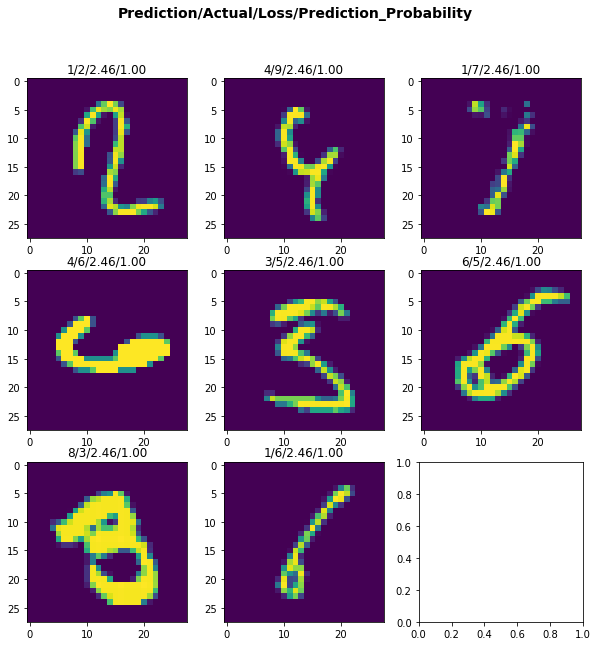

In [0]:
plot_top_losses(test_labels,test_pred,k=8)

### Adding top loss callback

In [0]:
class PlotTopLosses(tf.keras.callbacks.Callback):
    def __init__(self, k=3, frequency=2):
        self.k = k
        self.freq = frequency
        super(PlotTopLosses, self).__init__()
    def on_epoch_begin(self, epoch, logs=None):
        self.top_loss = defaultdict(list)
    def on_epoch_end(self, epoch, logs=None):
      if epoch%self.freq == 0:
          train_pred = self.model.predict(train_images)
          loss_values = self.model.loss(train_labels,train_pred).numpy()
          top_k = loss_values.argsort()[-self.k:][::-1]
          for index in top_k:
              actual_class = train_labels[index]
              loss_value = loss_values[index]
              predicted_class = np.argmax(train_pred[index])
              prob = train_pred[index][predicted_class]
              self.top_loss[epoch,index].append([predicted_class,actual_class,loss_value,prob])
          self.plot_losses(epoch)

    def plot_losses(self, epoch, figsize=(10, 10)):
        cols = math.ceil(math.sqrt(self.k))
        rows = math.ceil(self.k/cols)
        fig,axes = plt.subplots(rows, cols, figsize=figsize)
        fig.suptitle('Prediction/Actual/Loss/Prediction_Probability/epoch', weight='bold', size=14)
        
        i = 0
        print("Number of plots..",len(self.top_loss.items()))
        for ((epoch,index), plot_stuff) in self.top_loss.items():
            # Unpack the values
            image = train_images[index]
            actual_label = train_labels[index]
            loss_value = plot_stuff[0][2]
            predicted = plot_stuff[0][0]
            prob = plot_stuff[0][3]

            # Prepare the plot
            title = f'{predicted}/{actual_label}/{loss_value:.2f}/{prob:.2f}/{epoch}'
            ax = axes.flat[i]
            i+=1
            image = np.squeeze(image,axis=2)
            ax.imshow(image)
            ax.set_title(title)

Epoch 1/4
1875/1875 [==============================] - 69s 37ms/step - loss: 1.5854 - accuracy: 0.8778 - val_loss: 1.4818 - val_accuracy: 0.9804
Epoch 2/4
1875/1875 [==============================] - 56s 30ms/step - loss: 1.4856 - accuracy: 0.9762 - val_loss: 1.4765 - val_accuracy: 0.9849
Epoch 3/4
1875/1875 [==============================] - 55s 29ms/step - loss: 1.4797 - accuracy: 0.9819 - val_loss: 1.4792 - val_accuracy: 0.9820
Epoch 4/4
1875/1875 [==============================] - 69s 37ms/step - loss: 1.4776 - accuracy: 0.9836 - val_loss: 1.4788 - val_accuracy: 0.9826


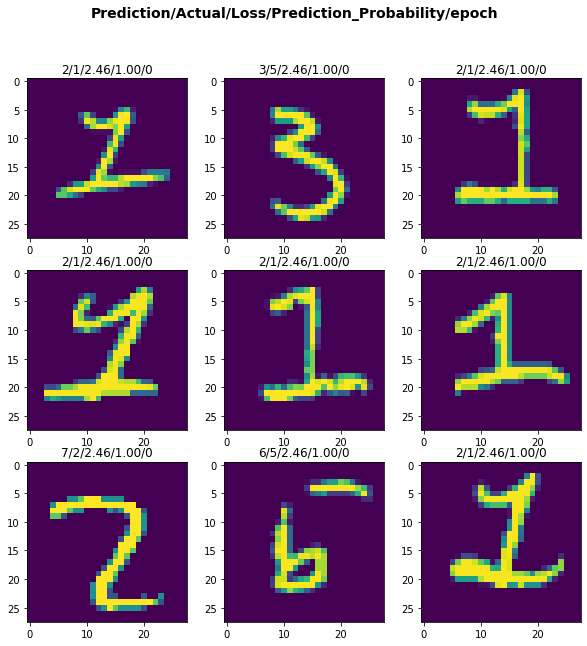

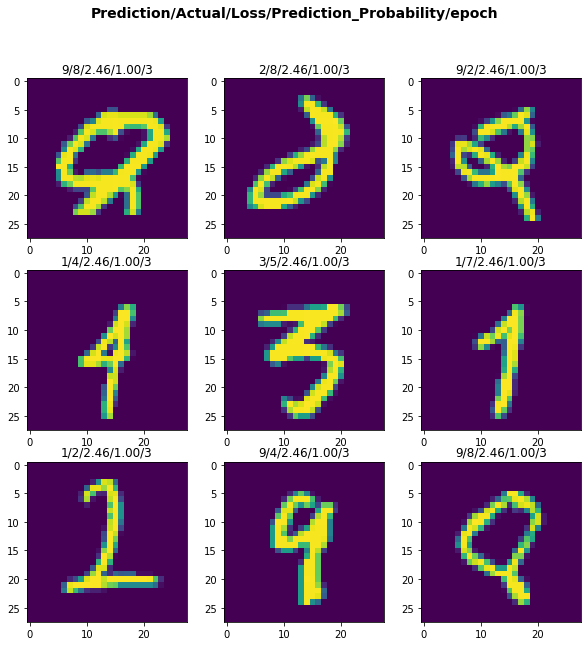

In [0]:
model = get_training_model()
history = model.fit(train_images, train_labels, epochs=4, 
                    validation_data=(test_images, test_labels),
                    callbacks=[PlotTopLosses(k=9,frequency=3)])